#SETUP

## Import Statements

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [2]:
import os
import numpy as np
from scipy.io import loadmat
from scipy.stats.stats import pearsonr

from __future__ import division

import seaborn as sns

## Fetching the Data

In [3]:
data_src = os.path.join(os.getenv("HOME"), 'Research/data/iabs-albedo')
cer = os.path.join(data_src, 'ceres.mat')

CERES = loadmat(cer)['dm'].T

## Function for resampling the CERES data to 4-degrees

In [4]:
# function for grid resampling
def coarsen_array(a, factor, exclude_nan=True):
    
    shp = a.shape    
    n_elements = factor**2
    
    # get the shapes using integer division and float division
    new_shape = tuple([shp[i]//factor for i in range(len(shp))])
    test_shape = tuple([shp[i]/factor for i in range(len(shp))])
    
    # if the two shapes are not equal, 
    # the grid is not equally divisible by the scale factor
    if new_shape != test_shape:
        raise Exception("Dimensions are not evenly divisible by {}"
                        .format(factor))
    
    # create our new array, adding a new dimension as the 0-th axis
    new_array = np.ones((n_elements,)+new_shape) * np.nan
    
    # check that new_array has the same total elements as array
    if not len(new_array.flatten())==len(a.flatten()):
        raise Exception("Original len {} doesn't match reshaped len {}".
                       format(len(a.flatten()), 
                              len(new_array.flatten())))
    
    counter = 0
    for i in range(factor):  # along the first dimension
        for j in range(factor):  # along the second dimension
            
            # insert into the new array every `factor-th` element
            # starting at the specified vertical and horizontal index
            new_array[counter,:] = a[i::factor, j::factor]
 
            counter += 1
 
    # two ways to calculate the mean when NANs are present in array:
    #   1. mean = NAN
    #   2. mean = mean of finite values
    if exclude_nan:
        return np.mean(new_array, axis=0).squeeze()
    else:
        return np.nanmean(new_array, axis=0).squeeze()

## Perform the resampling and mask the bad values

In [5]:
# coarsening the array, excluding NAN values
CERES_COARSE = coarsen_array(CERES, 4)
CERES_COARSE = np.ma.masked_where(np.isnan(CERES_COARSE), CERES_COARSE)

# coarsening the array, but keeping grid points with NAN values
CERES_COARSE_KEEPNAN = coarsen_array(CERES, 4, exclude_nan=False)
CERES_COARSE_KEEPNAN = np.ma.masked_where(np.isnan(CERES_COARSE_KEEPNAN), CERES_COARSE_KEEPNAN)

CERES = np.ma.masked_where(np.isnan(CERES), CERES)

/home/jstemm/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


## Some function definitions for mapping and plotting

In [6]:
## mapping properties
bmap_args = dict(projection='cyl',
                 resolution='c',
                 llcrnrlat=-60,
                 urcrnrlat=60,
                 llcrnrlon=-180,
                 urcrnrlon=180)

def map_stuff(m, ax):
    m.drawcoastlines()
    m.fillcontinents(zorder=1)
    m.drawparallels(np.arange(-90.,91.,30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,181.,60.), labels=[0, 0, 0, 1])
    m.drawmapboundary(fill_color='white')
    return m, ax

def draw_colorbar(fig, dat, **kwargs):
    
    cb = fig.colorbar(dat,
                      orientation=kwargs.pop('orientation', 'horizontal'),
                      fraction=kwargs.pop('fraction', 0.05),
                      pad=kwargs.pop('pad', 0.06),
                      **kwargs)
    return fig

def make_map(data, bmap_args, ax=None, fig=None, colorbar=True):
    
    if (ax is None) and (fig is None):
        fig, ax = plt.subplots(figsize=(16, 6))
    
    m = Basemap(ax=ax, **bmap_args)
    
    # get the resolution of the data
    l = (120, 360)
    lon_res, lat_res = [l[i]/r for i,r in enumerate(data.shape)]
    
    lons, lats = np.arange(-180, 180, lon_res), np.arange(-60, 60, lat_res)
    lons, lats = np.meshgrid(lons, lats)
    
    IMG = m.pcolormesh(lons, lats, data,
                      latlon=True, cmap=cm.RdBu_r,
                      vmin=-.4, vmax=.4, zorder=2)
    
    m = map_stuff(m, ax)
    if colorbar:
        fig = draw_colorbar(fig, IMG, ax=ax)
    else:
        pass
    
    return fig, ax

#Plotting

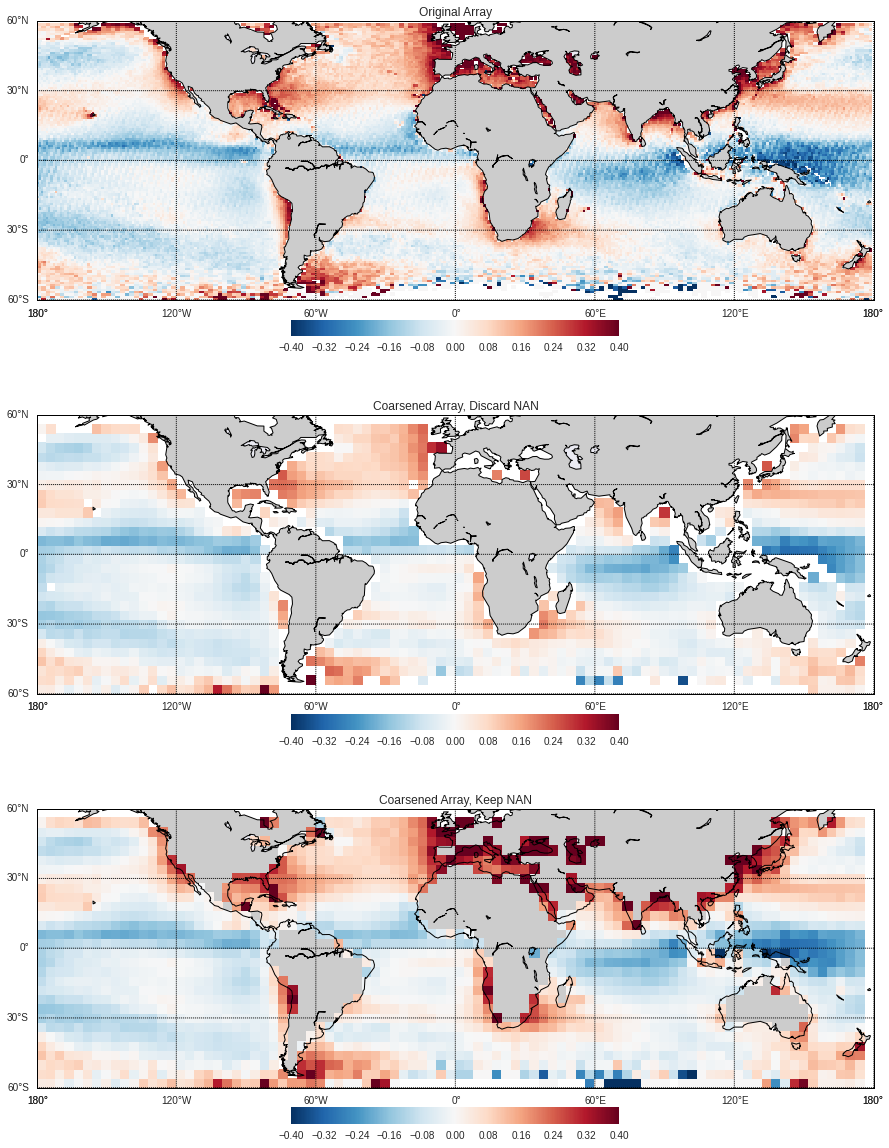

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 20))

fig, ax1 = make_map(CERES, bmap_args, fig=fig, ax=ax1)
ax1.set_title('Original Array')

fig, ax2 = make_map(CERES_COARSE, bmap_args, fig=fig, ax=ax2)
ax2.set_title('Coarsened Array, Discard NAN')

fig, ax3 = make_map(CERES_COARSE_KEEPNAN, bmap_args, fig=fig, ax=ax3)
ax3.set_title('Coarsened Array, Keep NAN')